In [ ]:
!pip install lightgbm
!pip install matplotlib
!pip install seaborn

In [1]:
import pandas  as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt 
from sklearn.impute import SimpleImputer
import warnings
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc ,accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import time
warnings.filterwarnings(action='ignore')

In [2]:
train = pd.read_csv('output_merged.csv')
train.shape

(1436700, 136)

In [3]:
train.columns

Index(['stream', 'src_mac', 'dst_mac', 'src_ip', 'dst_ip', 'src_port',
       'dst_port', 'inter_arrival_time',
       'time_since_previously_displayed_frame', 'port_class_dst',
       ...
       'min_p', 'max_p', 'med_p', 'average_p', 'var_p', 'q3_p', 'q1_p',
       'iqr_p', 'l3_ip_dst_count', 'label'],
      dtype='object', length=136)

In [4]:
train.select_dtypes('object').columns

Index(['src_mac', 'dst_mac', 'src_ip', 'dst_ip', 'handshake_version',
       'tls_server', 'http_request_method', 'http_host', 'user_agent',
       'dns_server', 'device_mac', 'eth_src_oui', 'eth_dst_oui',
       'highest_layer', 'http_uri', 'http_content_type', 'label'],
      dtype='object')

In [5]:
train.select_dtypes('number').columns

Index(['stream', 'src_port', 'dst_port', 'inter_arrival_time',
       'time_since_previously_displayed_frame', 'port_class_dst', 'l4_tcp',
       'l4_udp', 'ttl', 'eth_size',
       ...
       'sum_p', 'min_p', 'max_p', 'med_p', 'average_p', 'var_p', 'q3_p',
       'q1_p', 'iqr_p', 'l3_ip_dst_count'],
      dtype='object', length=119)

In [6]:
train.isnull().sum() / train.shape[0] *100

stream             0.000000
src_mac            0.000000
dst_mac            0.000000
src_ip             4.971045
dst_ip             4.971045
                     ...   
q3_p               0.000000
q1_p               0.000000
iqr_p              0.000000
l3_ip_dst_count    0.000000
label              0.000000
Length: 136, dtype: float64

In [7]:
nan_percentage = train.isnull().sum() / train.shape[0] * 100
high_nan_columns = nan_percentage[nan_percentage > 60]
high_nan_columns

dns_query_type    95.055335
dtype: float64

In [8]:
train_filter = train.drop(columns=['src_mac', 'dst_mac', 'src_ip', 'dst_ip'])
train_filter

,stream,src_port,dst_port,inter_arrival_time,time_since_previously_displayed_frame,port_class_dst,l4_tcp,l4_udp,ttl,eth_size,...,min_p,max_p,med_p,average_p,var_p,q3_p,q1_p,iqr_p,l3_ip_dst_count,label
0,0,443,48531,0.000000,0.000000,2,1,0,233,66,...,12.0,12.0,12.0,12.0,0.000000,12.0,12.0,0.0,1.0,Backdoor_Malware
1,-1,0,0,0.102862,0.102862,2,0,0,0,60,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,Backdoor_Malware
2,-1,0,0,0.187258,0.084396,2,0,0,0,60,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,Backdoor_Malware
3,1,443,54482,0.189870,0.002612,3,1,0,60,66,...,12.0,12.0,12.0,12.0,0.000000,12.0,12.0,0.0,1.0,Backdoor_Malware
4,-1,0,0,0.396113,0.206243,3,0,0,0,60,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,Backdoor_Malware
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1436695,-1,0,0,2400.568512,0.067105,1,0,0,0,60,...,0.0,188.0,188.0,122.2,8463.957895,188.0,0.0,188.0,2.0,XSS
1436696,-1,0,0,2400.599149,0.030637,0,0,0,64,78,...,0.0,48.0,9.0,13.8,294.694737,20.0,0.0,20.0,97.0,XSS
1436697,78,24812,32100,2400.631154,0.032005,2,0,1,64,150,...,0.0,108.0,9.0,18.3,739.484211,20.0,0.0,20.0,97.0,XSS
1436698,79,24812,32100,2400.635925,0.004771,2,0,1,64,150,...,0.0,108.0,9.0,22.7,1142.431579,27.0,0.0,27.0,97.0,XSS


In [9]:
for col in train_filter.select_dtypes(include=['object']).columns :
    le = LabelEncoder()
    if col != 'label':
        train_filter[col] = le.fit_transform(train_filter[col].astype(str))
train_filter.select_dtypes('number').columns

Index(['stream', 'src_port', 'dst_port', 'inter_arrival_time',
       'time_since_previously_displayed_frame', 'port_class_dst', 'l4_tcp',
       'l4_udp', 'ttl', 'eth_size',
       ...
       'sum_p', 'min_p', 'max_p', 'med_p', 'average_p', 'var_p', 'q3_p',
       'q1_p', 'iqr_p', 'l3_ip_dst_count'],
      dtype='object', length=131)

In [10]:
le_l = LabelEncoder()
train_filter['label'] = le_l.fit_transform(train_filter['label'])
label_names = le_l.classes_

In [11]:
train_filter = train_filter.fillna(train_filter.mean())

In [12]:
train_filter.duplicated().sum()


np.int64(0)

In [13]:
train_filter.describe()

,stream,src_port,dst_port,inter_arrival_time,time_since_previously_displayed_frame,port_class_dst,l4_tcp,l4_udp,ttl,eth_size,...,min_p,max_p,med_p,average_p,var_p,q3_p,q1_p,iqr_p,l3_ip_dst_count,label
count,1.436700e+06,1.436700e+06,1.436700e+06,1.436700e+06,1.436700e+06,1.436700e+06,1.436700e+06,1.436700e+06,1.436700e+06,1.436700e+06,...,1.436700e+06,1.436700e+06,1.436700e+06,1.436700e+06,1.436700e+06,1.436700e+06,1.436700e+06,1.436700e+06,1.436700e+06,1.436700e+06
mean,9.262196e+02,2.579932e+04,2.232676e+04,1.583068e+03,1.800393e-02,1.802048e+00,7.317046e-01,2.014178e-01,1.076211e+02,4.932918e+02,...,5.542893e+01,1.699037e+03,3.241463e+02,4.388254e+02,5.975988e+05,5.623024e+02,1.475705e+02,4.147320e+02,2.745799e+01,1.380920e+00
std,1.990004e+03,2.391621e+04,2.356260e+04,1.118031e+03,1.977653e+00,7.970524e-01,4.430724e-01,4.010596e-01,8.115479e+01,9.400613e+02,...,2.489528e+02,2.420781e+03,5.657090e+02,5.625787e+02,1.543728e+06,7.424605e+02,4.074553e+02,6.360779e+02,2.893857e+01,1.116092e+00
min,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,1.700000e+01,4.430000e+02,4.430000e+02,6.924723e+02,4.100000e-04,1.000000e+00,0.000000e+00,0.000000e+00,6.400000e+01,6.600000e+01,...,0.000000e+00,1.630000e+02,1.200000e+01,5.700000e+01,2.220168e+03,4.400000e+01,1.200000e+01,1.550000e+01,6.000000e+00,1.000000e+00
50%,2.550000e+02,3.348100e+04,6.667000e+03,1.448443e+03,3.377000e-03,2.000000e+00,1.000000e+00,0.000000e+00,6.400000e+01,7.700000e+01,...,1.200000e+01,4.050000e+02,3.350000e+01,1.165500e+02,1.430121e+04,1.107500e+02,1.200000e+01,9.000000e+01,1.300000e+01,1.000000e+00
75%,8.400000e+02,4.915400e+04,4.591900e+04,2.256453e+03,1.562500e-02,2.000000e+00,1.000000e+00,0.000000e+00,2.310000e+02,2.630000e+02,...,1.200000e+01,2.908000e+03,1.880000e+02,7.657000e+02,5.834148e+05,1.460000e+03,1.650000e+01,3.620000e+02,4.400000e+01,1.000000e+00
max,1.550700e+04,6.552800e+04,6.552800e+04,5.204651e+03,1.919823e+03,3.000000e+00,1.000000e+00,1.000000e+00,2.550000e+02,3.047400e+04,...,4.356000e+03,3.042000e+04,4.380000e+03,4.790400e+03,4.831281e+07,6.166000e+03,4.356000e+03,5.792000e+03,1.140000e+02,6.000000e+00


In [14]:
train_filter.sample(10)

,stream,src_port,dst_port,inter_arrival_time,time_since_previously_displayed_frame,port_class_dst,l4_tcp,l4_udp,ttl,eth_size,...,min_p,max_p,med_p,average_p,var_p,q3_p,q1_p,iqr_p,l3_ip_dst_count,label
33444,0,56891,443,1.327425,0.003703,1,1,0,64,1514,...,12.0,2908.0,1460.0,1432.95,434501.207895,1460.00,1460.0,0.00,2.0,1
799208,42,55444,55444,1647.095502,0.020272,3,0,1,64,60,...,0.0,163.0,18.0,37.75,2603.144737,18.00,18.0,0.00,13.0,1
1435861,1,443,54482,2373.680819,0.003546,3,1,0,59,66,...,12.0,230.0,57.0,63.40,3557.094737,102.00,12.0,90.00,2.0,6
598631,1043,443,33328,2483.006098,0.018071,2,1,0,231,66,...,12.0,2191.0,20.0,365.20,446227.957895,165.25,12.0,153.25,74.0,1
11139,186,443,37776,1286.648898,0.000111,2,1,0,244,1494,...,61.0,1440.0,1440.0,1371.05,95082.050000,1440.00,1440.0,0.00,12.0,0
818638,0,41206,443,1845.390449,0.005837,1,1,0,64,156,...,12.0,102.0,57.0,57.00,2131.578947,102.00,12.0,90.00,2.0,1
364168,4,41206,443,319.699287,0.015053,1,1,0,64,156,...,12.0,102.0,57.0,57.00,2131.578947,102.00,12.0,90.00,2.0,1
469175,4,41206,443,1297.588801,0.000611,1,1,0,64,156,...,12.0,102.0,57.0,57.00,2131.578947,102.00,12.0,90.00,2.0,1
578014,973,443,43894,2294.908493,0.005473,2,1,0,231,66,...,12.0,1460.0,12.0,129.90,139305.042105,12.00,12.0,0.00,73.0,1
59923,52,50856,6667,253.938174,0.028046,2,0,1,64,230,...,6.0,421.0,12.0,114.10,21600.410526,188.00,6.0,182.00,7.0,1


In [15]:
X_train, X_test, y_train, y_test = train_test_split(train_filter.drop('label',axis=1), 
                                                    train_filter['label'], test_size=0.20, 
                                                    random_state=101)

In [16]:
x_train  = preprocessing.StandardScaler().fit_transform(X_train.values)
x_test  = preprocessing.StandardScaler().fit_transform(X_test.values)

In [ ]:
all_reports = []
performance_metrics = []
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score


def train_and_collect(model, model_name):
    start_train = time.time()
    model.fit(x_train, y_train)
    end_train = time.time()
    training_time = end_train - start_train

    start_inference = time.time()
    y_pred = model.predict(x_test)
    end_inference = time.time()
    inference_time_total = end_inference - start_inference
    inference_time_per_sample = inference_time_total / len(x_test)
    
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(x_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    roc_auc = None
    if hasattr(model, "predict_proba") and len(np.unique(y_test)) > 2:
        roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    elif hasattr(model, "predict_proba"):
        roc_auc = roc_auc_score(y_test, y_proba[:, 1])
    
    report = classification_report(y_test, y_pred, target_names=label_names, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report['model'] = model_name
    df_report['label'] = df_report.index
    df_report['type'] = 'classification_report'
    all_reports.append(df_report)
    
    metrics_dict = {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'training_time': training_time,
        'inference_time_total': inference_time_total,
        'inference_time_per_sample': inference_time_per_sample,
        'roc_auc': roc_auc
    }
    performance_metrics.append(metrics_dict)
    
    print(f"\n{'='*50}")
    print(f"Model: {model_name}")
    print(f"{'='*50}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if roc_auc is not None:
        print(f"ROC AUC: {roc_auc:.4f}")
    print(f"\nTraining Time: {training_time:.4f} seconds")
    print(f"Inference Time (total): {inference_time_total:.4f} seconds")
    print(f"Inference Time (per sample): {inference_time_per_sample:.6f} seconds")
    print(f"{'='*50}\n")
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names, cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
    if hasattr(model, "predict_proba"):
        if len(np.unique(y_test)) == 2: 
            fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - {model_name}')
            plt.legend(loc="lower right")
            plt.show()
        else:  
            plt.figure(figsize=(8, 6))
            for i in range(len(label_names)):
                fpr, tpr, _ = roc_curve(y_test == i, y_proba[:, i])
                plt.plot(fpr, tpr, label=f'{label_names[i]} (AUC = {roc_auc_score(y_test == i, y_proba[:, i]):.2f})')
            
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curves - {model_name}')
            plt.legend(loc="lower right")
            plt.show()


Model: RandomForest
Accuracy: 0.9735
Precision: 0.9732
Recall: 0.9735
F1 Score: 0.9725
ROC AUC: 0.9971

Training Time: 1494.0615 seconds
Inference Time (total): 7.4931 seconds
Inference Time (per sample): 0.000026 seconds



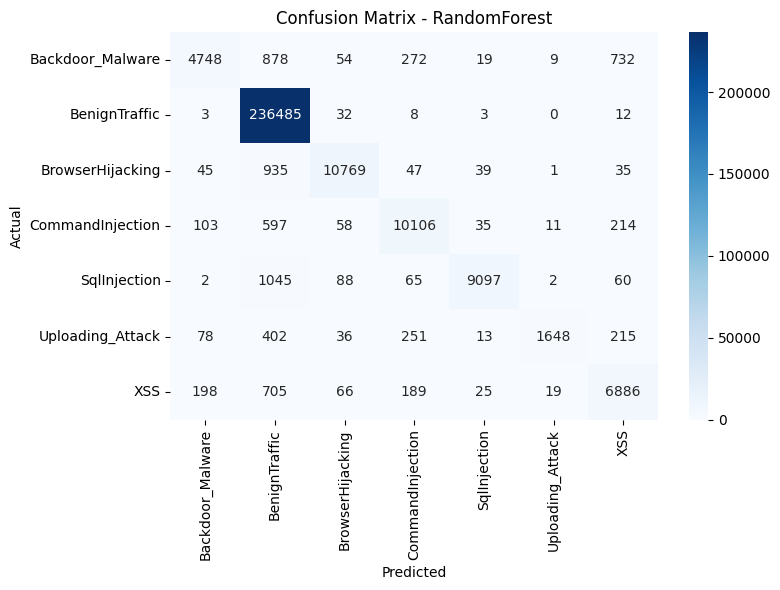

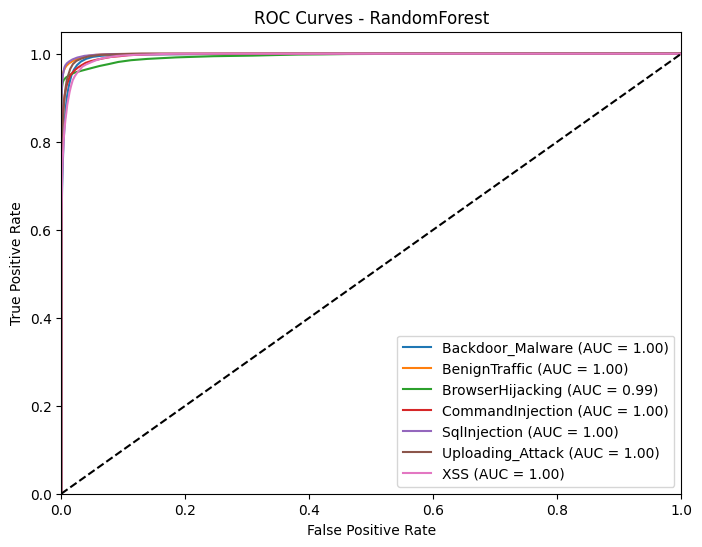

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.375282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26080
[LightGBM] [Info] Number of data points in the train set: 1149360, number of used features: 129
[LightGBM] [Info] Start training from score -3.764659
[LightGBM] [Info] Start training from score -0.194448
[LightGBM] [Info] Start training from score -3.188402
[LightGBM] [Info] Start training from score -3.251292
[LightGBM] [Info] Start training from score -3.302907
[LightGBM] [Info] Start training from score -4.716663
[LightGBM] [Info] Start training from score -3.580818

Model: LightGBM
Accuracy: 0.9828
Precision: 0.9831
Recall: 0.9828
F1 Score: 0.9828
ROC AUC: 0.9992

Training Time: 100.8370 seconds
Inference Time (total): 2.1052 seconds
Inference Time (per sample): 0.000007 seconds



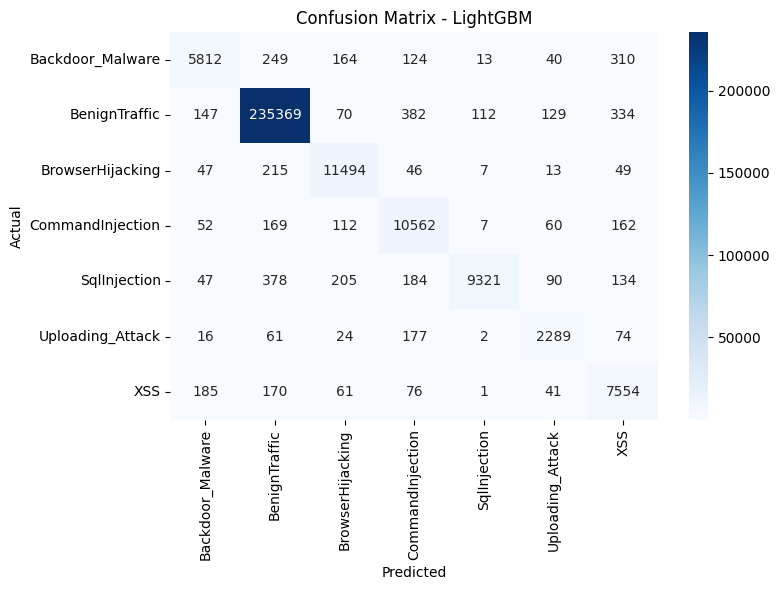

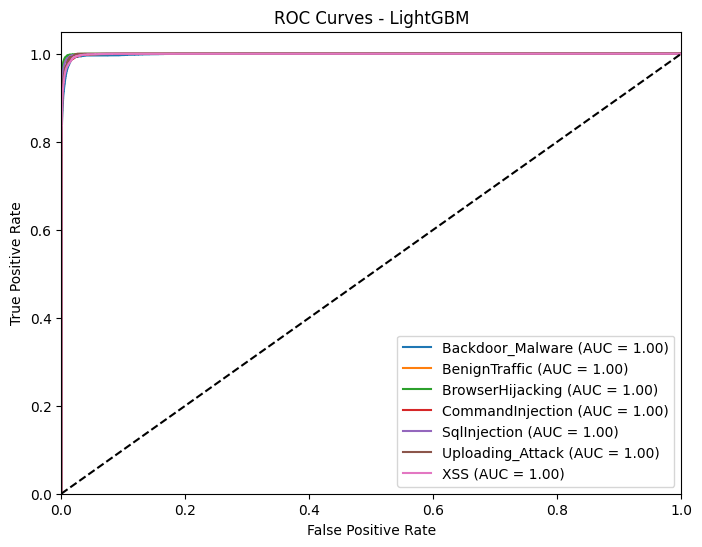


Model: MLP
Accuracy: 0.9619
Precision: 0.9606
Recall: 0.9619
F1 Score: 0.9610
ROC AUC: 0.9960

Training Time: 2942.6989 seconds
Inference Time (total): 0.5102 seconds
Inference Time (per sample): 0.000002 seconds



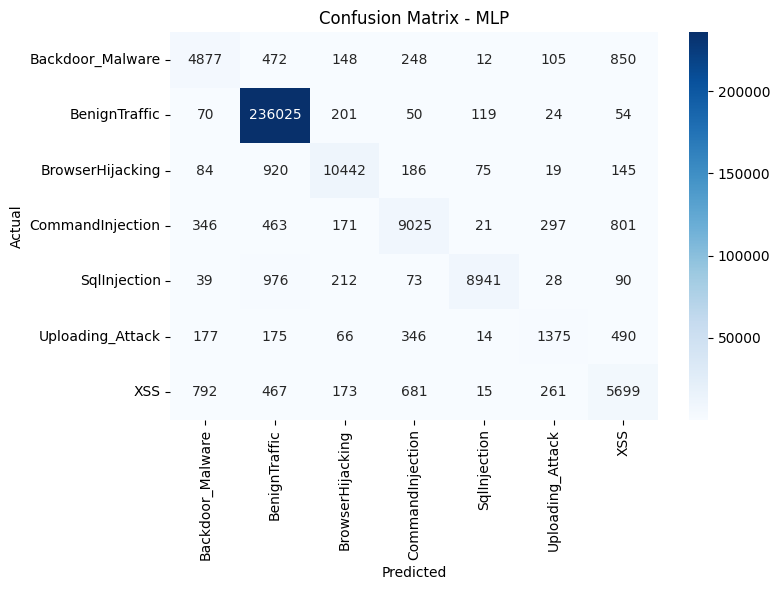

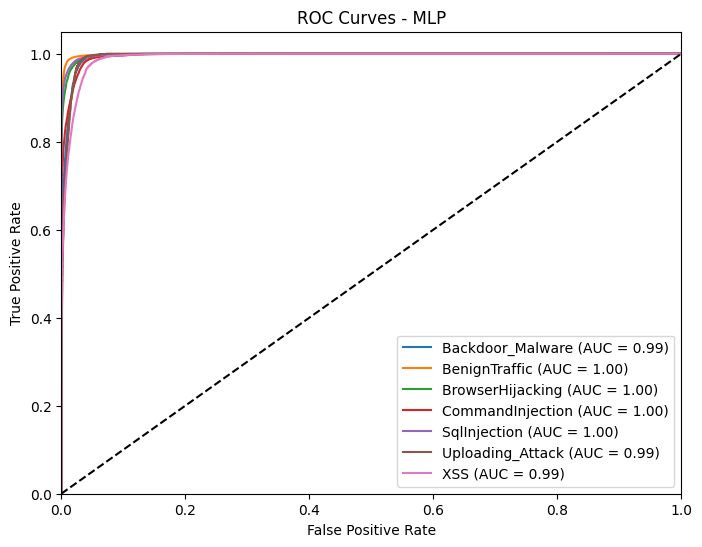

In [20]:
train_and_collect(RandomForestClassifier(random_state=42), 'RandomForest')
train_and_collect(LGBMClassifier(random_state=42), 'LightGBM')
train_and_collect(MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42), 'MLP')



In [21]:
y_categorical = to_categorical(train_filter['label'])
X_train, X_test, y_train, y_test = train_test_split(train_filter.drop('label',axis=1), 
                                                    y_categorical, test_size=0.30, 
                                                    random_state=101)

x_train  = preprocessing.StandardScaler().fit_transform(X_train.values)
x_test  = preprocessing.StandardScaler().fit_transform(X_test.values)
y_categorical

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])


DNN Performance:
Accuracy: 0.9342
Precision: 0.9280
Recall: 0.9342
F1-Score: 0.9292
AUC-ROC: 0.9954
Training Time: 1112.73s
Inference Time: 19.14s


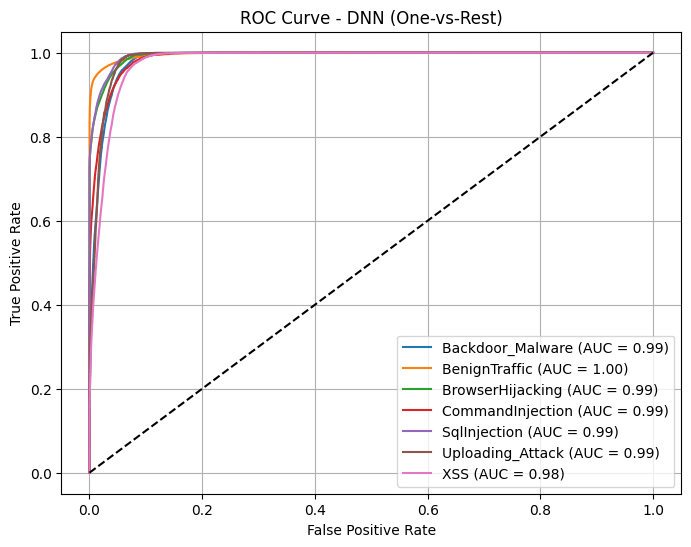

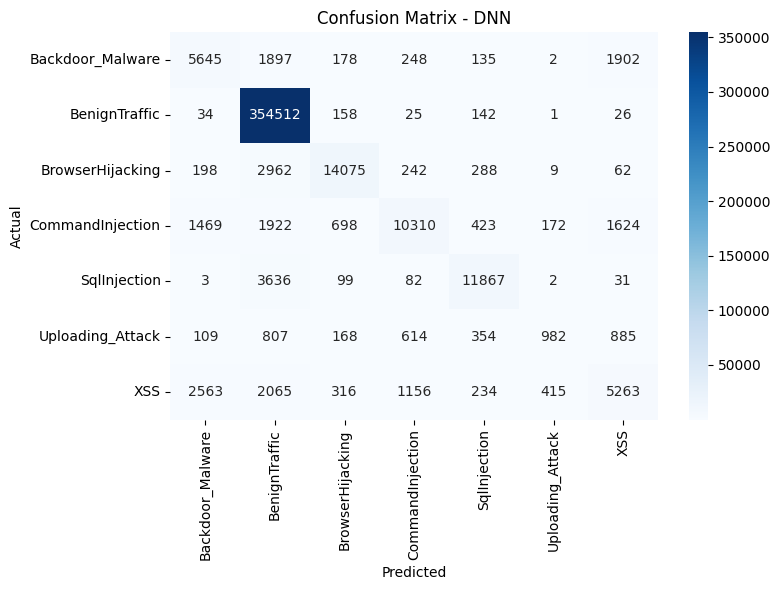

In [24]:
#     DNN model

import tensorflow as tf

y_categorical = to_categorical(train_filter['label'])
model = Sequential([
    Dense(128, input_dim=x_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_categorical.shape[1], activation='softmax')
])

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

start_train = time.time()
history = model.fit(x_train, y_train, epochs=20, batch_size=32, verbose=0)
end_train = time.time()
training_time = end_train - start_train

start_inference = time.time()
y_pred = model.predict(x_test, verbose=0)
end_inference = time.time()
inference_time_total = end_inference - start_inference
inference_time_per_sample = inference_time_total / x_test.shape[0]

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
y_proba = y_pred  

accuracy = accuracy_score(y_test_labels, y_pred_labels)
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
auc_roc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')

report = classification_report(y_test_labels, y_pred_labels, 
                             target_names=label_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report['model'] = 'DNN'
df_report['label'] = df_report.index
df_report['type'] = 'classification_report'
df_report['auc_roc'] = auc_roc
df_report['training_time'] = training_time
df_report['inference_time_total'] = inference_time_total
df_report['inference_time_per_sample'] = inference_time_per_sample
all_reports.append(df_report)

print('\nDNN Performance:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}') 
print(f'F1-Score: {f1:.4f}')
print(f'AUC-ROC: {auc_roc:.4f}')
print(f'Training Time: {training_time:.2f}s')
print(f'Inference Time: {inference_time_total:.2f}s')


plt.figure(figsize=(8, 6))
n_classes = y_proba.shape[1]
for i in range(n_classes):
    if np.sum(y_test[:, i]) > 0: 
        fpr, tpr, _ = roc_curve(y_test[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - DNN (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_labels, y_pred_labels), 
            annot=True, fmt='d',
            xticklabels=label_names,
            yticklabels=label_names,
            cmap='Blues')
plt.title('Confusion Matrix - DNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


Dense DNN Evaluation:
Accuracy: 0.9462
Precision: 0.9434
Recall: 0.9462
F1-Score: 0.9426
AUC-ROC: 0.9972
Training Time: 1776.02s
Inference Time: 30.12s


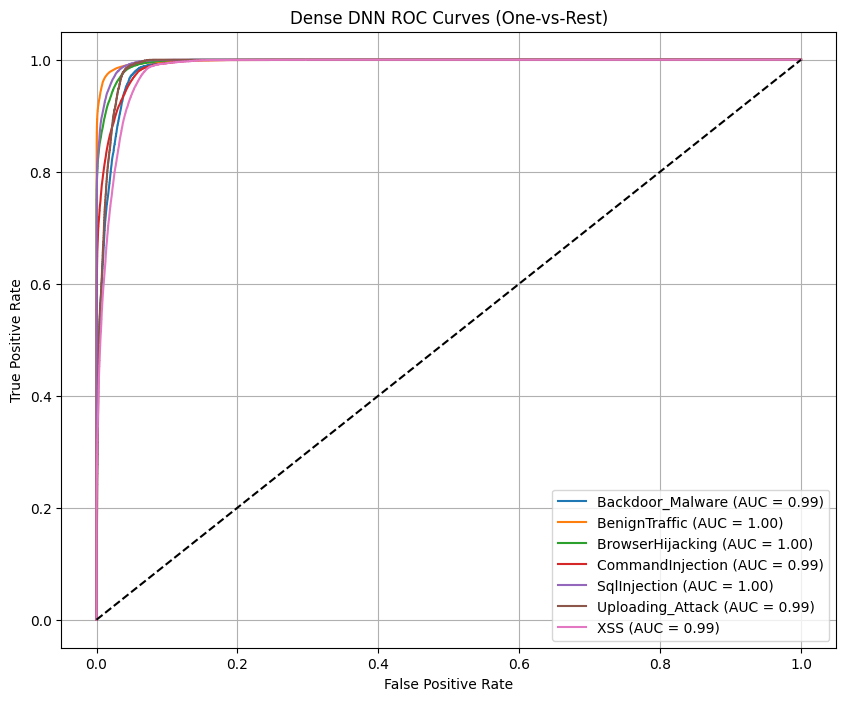

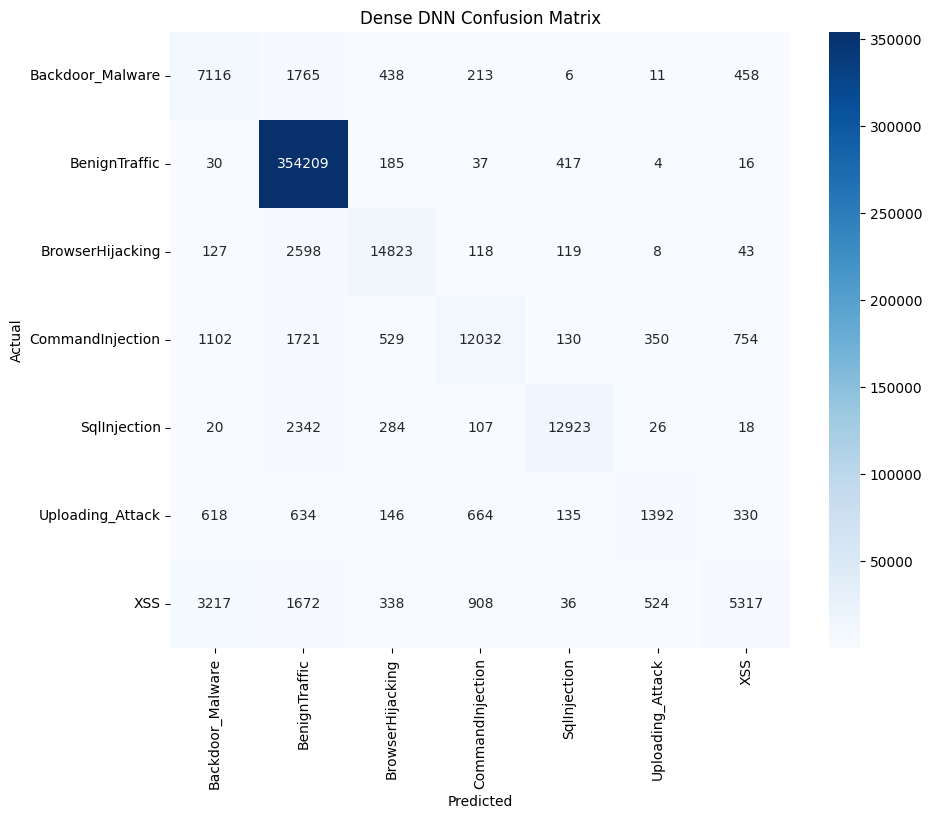

In [25]:
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Add, Input
from tensorflow.keras.models import Model
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def build_dnn(input_shape, num_classes):
    inputs = Input(shape=(input_shape,))
    
    # Block 1
    x = Dense(128, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Residual connection
    residual = Dense(64, activation='relu')(x)
    x = BatchNormalization()(residual)
    x = Dropout(0.3)(x)
    
    # Block 2
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Skip connection
    x = Add()([x, residual])
    
    # Output
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

# Build and train model
model = build_dnn(x_train.shape[1], y_categorical.shape[1])

# Training
start_train = time.time()
history = model.fit(x_train, y_train, epochs=20, batch_size=32, verbose=0)
end_train = time.time()
training_time = end_train - start_train

# Prediction
start_inference = time.time()
y_pred_proba = model.predict(x_test, verbose=0)
end_inference = time.time()
inference_time = end_inference - start_inference

# Metrics calculation
y_pred = np.argmax(y_pred_proba, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_labels, y_pred)
precision = precision_score(y_test_labels, y_pred, average='weighted')
recall = recall_score(y_test_labels, y_pred, average='weighted')
f1 = f1_score(y_test_labels, y_pred, average='weighted')
auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')

# Store results
report = classification_report(y_test_labels, y_pred, target_names=label_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report['model'] = 'Dense DNN'
df_report['auc_roc'] = auc_roc
df_report['training_time'] = training_time
df_report['inference_time'] = inference_time
all_reports.append(df_report)

# Print metrics
print(f"\nDense DNN Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Training Time: {training_time:.2f}s")
print(f"Inference Time: {inference_time:.2f}s")

# ROC Curve
plt.figure(figsize=(10, 8))
for i in range(len(label_names)):
    if np.sum(y_test[:, i]) > 0:  # Only plot if class has samples
        fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        plt.plot(fpr, tpr, label=f'{label_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Dense DNN ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test_labels, y_pred),
            annot=True, fmt='d',
            xticklabels=label_names,
            yticklabels=label_names,
            cmap='Blues')
plt.title('Dense DNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


SNN (Self-Normalizing Neural Network) Performance:
Accuracy: 0.9400
Precision: 0.9445
Recall: 0.9400
F1-Score: 0.9393
AUC-ROC: 0.9964
Training Time: 944.13s
Inference Time: 10.56s
Inference Time per Sample: 0.000025s


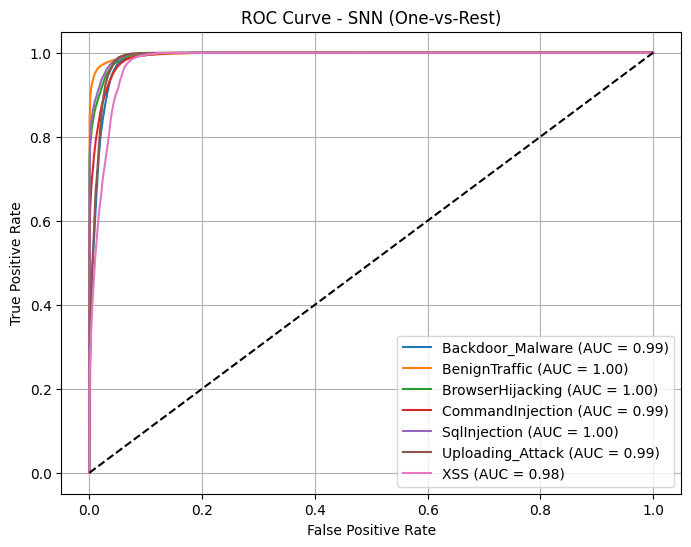

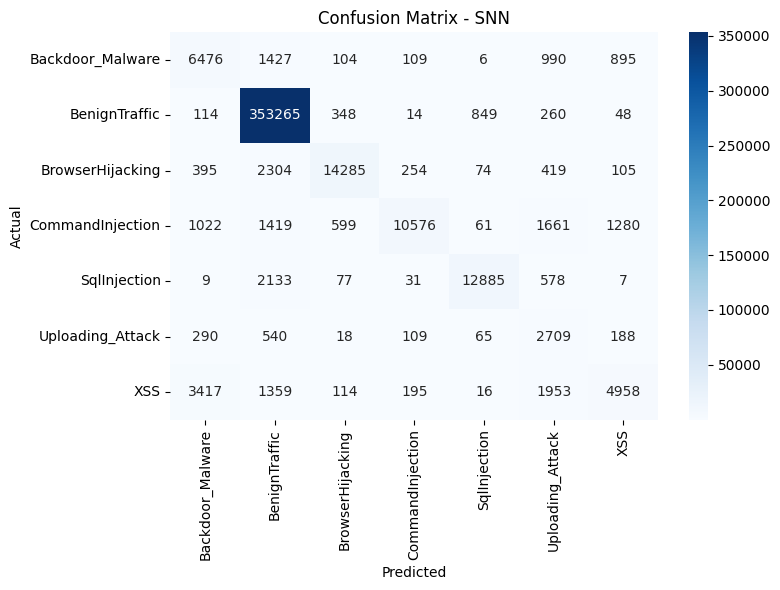

In [26]:
from tensorflow.keras.layers import AlphaDropout  
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

def build_snn(input_shape, num_classes):
    model = Sequential([
        Dense(128, activation='selu', input_shape=(input_shape,)),
        AlphaDropout(0.2),
        Dense(64, activation='selu'),
        AlphaDropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

model = build_snn(x_train.shape[1], y_categorical.shape[1])

start_train = time.time()
history = model.fit(x_train, y_train, epochs=20, batch_size=32, verbose=0)
end_train = time.time()
training_time = end_train - start_train

start_inference = time.time()
y_pred_proba = model.predict(x_test, verbose=0)
end_inference = time.time()
inference_time_total = end_inference - start_inference
inference_time_per_sample = inference_time_total / x_test.shape[0]

y_pred_labels = np.argmax(y_pred_proba, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')

report = classification_report(y_test_labels, y_pred_labels, 
                             target_names=label_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report['model'] = 'SNN'
df_report['label'] = df_report.index
df_report['type'] = 'classification_report'
df_report['auc_roc'] = auc_roc
df_report['training_time'] = training_time
df_report['inference_time_total'] = inference_time_total
df_report['inference_time_per_sample'] = inference_time_per_sample
all_reports.append(df_report)

print('\nSNN (Self-Normalizing Neural Network) Performance:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}') 
print(f'F1-Score: {f1:.4f}')
print(f'AUC-ROC: {auc_roc:.4f}')
print(f'Training Time: {training_time:.2f}s')
print(f'Inference Time: {inference_time_total:.2f}s')
print(f'Inference Time per Sample: {inference_time_per_sample:.6f}s')

plt.figure(figsize=(8, 6))
n_classes = y_pred_proba.shape[1]
for i in range(n_classes):
    if np.sum(y_test[:, i]) > 0: 
        fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SNN (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_labels, y_pred_labels), 
            annot=True, fmt='d',
            xticklabels=label_names,
            yticklabels=label_names,
            cmap='Blues')
plt.title('Confusion Matrix - SNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()



DeepFM Performance:
Accuracy: 0.9354
Precision: 0.9305
Recall: 0.9354
F1-Score: 0.9305
AUC-ROC: 0.9960
Training Time: 676.86s
Inference Time: 10.82s
Inference Time per Sample: 0.000025s


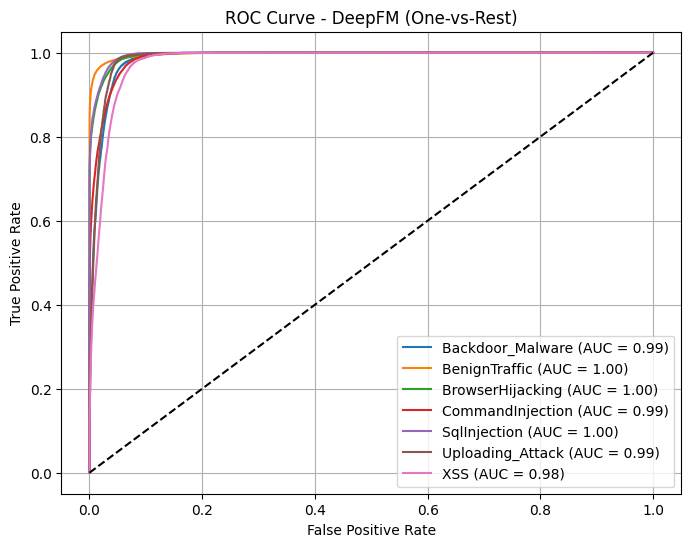

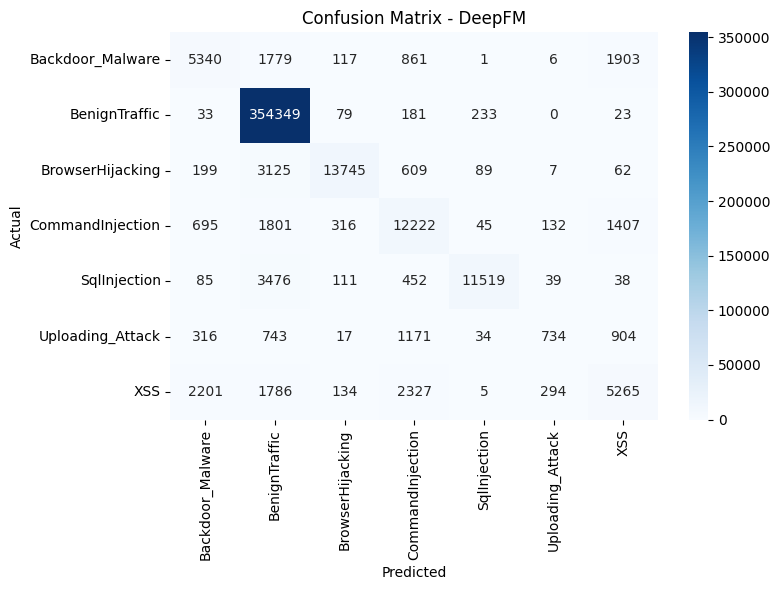

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Add, Concatenate, Lambda
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

def deepfm(input_shape, num_classes):
    inputs = Input(shape=(input_shape,))
    
    linear = Dense(1, activation=None)(inputs)
    
    def fm_interaction(x):
        sum_of_squares = tf.reduce_sum(tf.square(x), axis=1, keepdims=True)
        square_of_sum = tf.square(tf.reduce_sum(x, axis=1, keepdims=True))
        return 0.5 * (square_of_sum - sum_of_squares)
    
    interaction = Lambda(fm_interaction)(inputs)
    interaction = Dense(1, activation=None)(interaction)
    
    fm = Add()([linear, interaction])
    
    dnn = Dense(128, activation='relu')(inputs)
    dnn = Dropout(0.3)(dnn)
    dnn = Dense(64, activation='relu')(dnn)
    dnn = Dropout(0.3)(dnn)
    
    combined = Concatenate()([fm, dnn])
    outputs = Dense(num_classes, activation='softmax')(combined)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

model = deepfm(x_train.shape[1], y_categorical.shape[1])

start_train = time.time()
history = model.fit(x_train, y_train, epochs=20, batch_size=32, verbose=0)
end_train = time.time()
training_time = end_train - start_train

start_inference = time.time()
y_pred_proba = model.predict(x_test, verbose=0)
end_inference = time.time()
inference_time_total = end_inference - start_inference
inference_time_per_sample = inference_time_total / x_test.shape[0]

y_pred_labels = np.argmax(y_pred_proba, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')

report = classification_report(y_test_labels, y_pred_labels, 
                             target_names=label_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report['model'] = 'DeepFM'
df_report['label'] = df_report.index
df_report['type'] = 'classification_report'
df_report['auc_roc'] = auc_roc
df_report['training_time'] = training_time
df_report['inference_time_total'] = inference_time_total
df_report['inference_time_per_sample'] = inference_time_per_sample
all_reports.append(df_report)

print('\nDeepFM Performance:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}') 
print(f'F1-Score: {f1:.4f}')
print(f'AUC-ROC: {auc_roc:.4f}')
print(f'Training Time: {training_time:.2f}s')
print(f'Inference Time: {inference_time_total:.2f}s')
print(f'Inference Time per Sample: {inference_time_per_sample:.6f}s')

plt.figure(figsize=(8, 6))
n_classes = y_pred_proba.shape[1]
for i in range(n_classes):
    if np.sum(y_test[:, i]) > 0: 
        fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - DeepFM (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_labels, y_pred_labels), 
            annot=True, fmt='d',
            xticklabels=label_names,
            yticklabels=label_names,
            cmap='Blues')
plt.title('Confusion Matrix - DeepFM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


Tab Transformer Performance:
Accuracy: 0.9245
Precision: 0.9171
Recall: 0.9245
F1-Score: 0.9172
AUC-ROC: 0.9918
Training Time: 13074.65s
Inference Time: 30.67s
Inference Time per Sample: 0.000071s


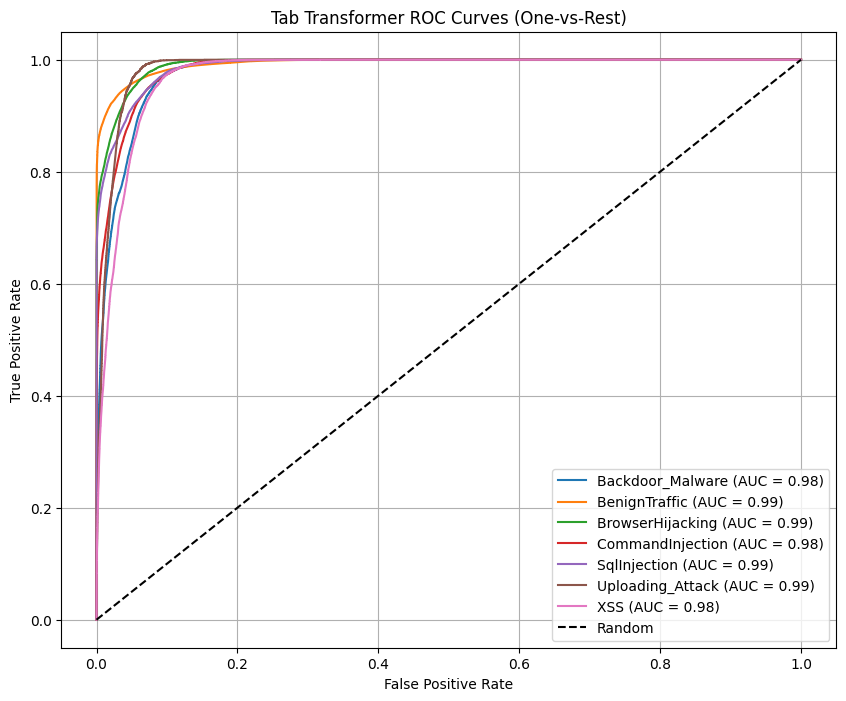

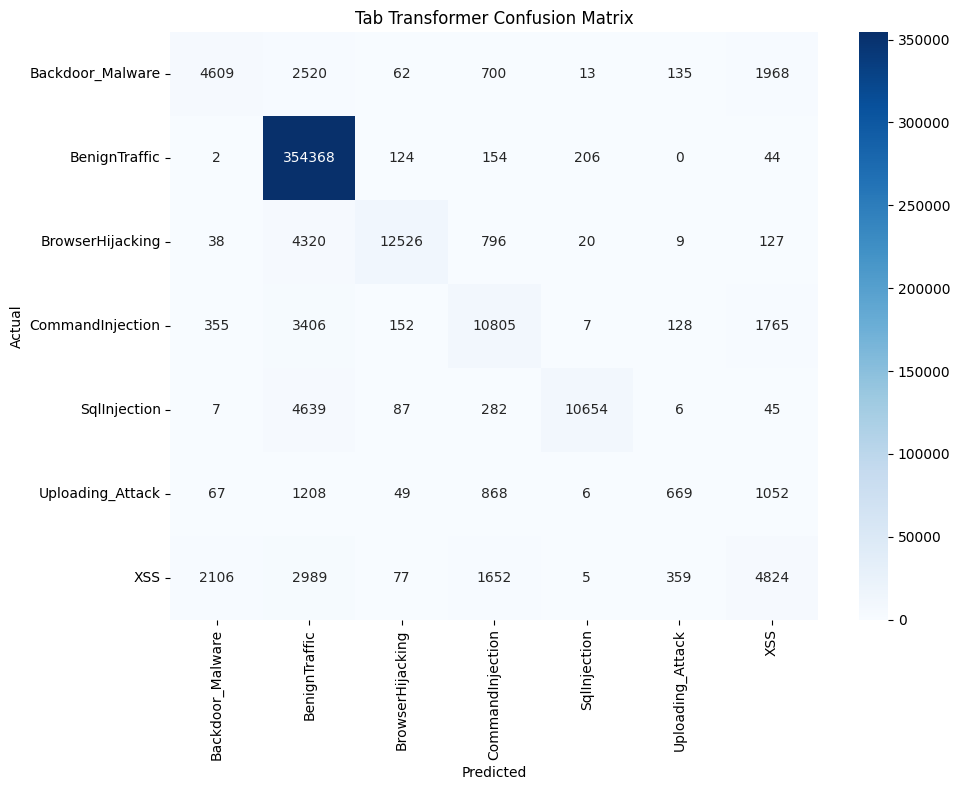

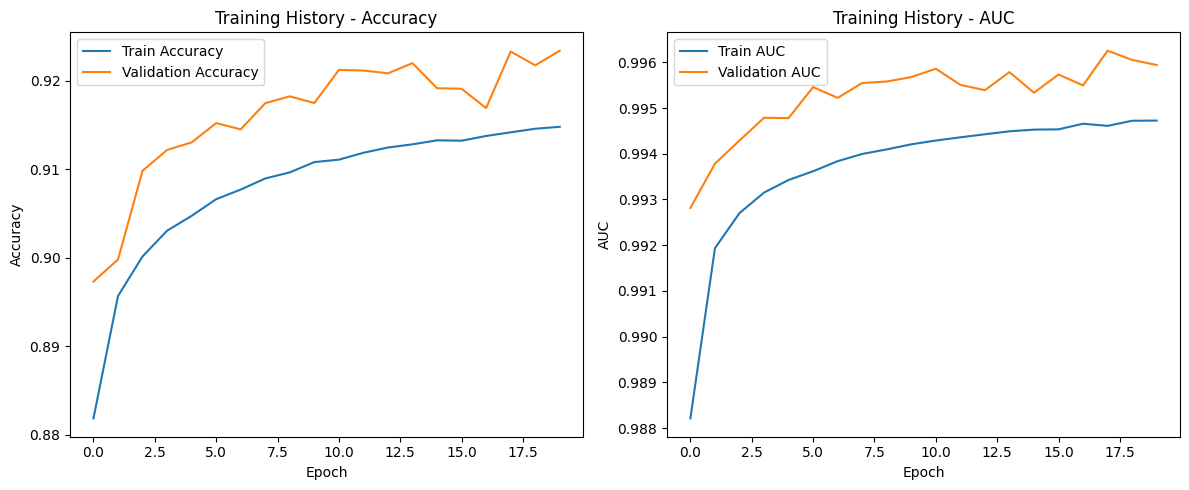

In [28]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Flatten, Input, Dense, Dropout, Lambda
from tensorflow.keras.models import Model
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

def tab_transformer(input_shape, num_classes, num_heads=4):
    inputs = Input(shape=(input_shape,))
    
    def expand_dims(x):
        return tf.expand_dims(x, axis=1)  
    x = Lambda(expand_dims)(inputs)
    
    attn_output = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=input_shape,
        dropout=0.1
    )(x, x)  

    x = LayerNormalization()(attn_output + x)
    x = Flatten()(x)
    
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

model = tab_transformer(x_train.shape[1], y_categorical.shape[1])

start_train = time.time()
history = model.fit(
    x_train, y_train,
    epochs=20,
    batch_size=32,
    verbose=0,
    validation_split=0.1
)
end_train = time.time()
training_time = end_train - start_train

start_inference = time.time()
y_pred_proba = model.predict(x_test, verbose=0)
end_inference = time.time()
inference_time_total = end_inference - start_inference
inference_time_per_sample = inference_time_total / x_test.shape[0]

y_pred_labels = np.argmax(y_pred_proba, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')

report = classification_report(y_test_labels, y_pred_labels, 
                             target_names=label_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report['model'] = 'Tab Transformer'
df_report['label'] = df_report.index
df_report['type'] = 'classification_report'
df_report['auc_roc'] = auc_roc
df_report['training_time'] = training_time
df_report['inference_time_total'] = inference_time_total
df_report['inference_time_per_sample'] = inference_time_per_sample
all_reports.append(df_report)

print('\nTab Transformer Performance:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}') 
print(f'F1-Score: {f1:.4f}')
print(f'AUC-ROC: {auc_roc:.4f}')
print(f'Training Time: {training_time:.2f}s')
print(f'Inference Time: {inference_time_total:.2f}s')
print(f'Inference Time per Sample: {inference_time_per_sample:.6f}s')


plt.figure(figsize=(10, 8))
n_classes = y_pred_proba.shape[1]
for i in range(n_classes):
    if np.sum(y_test[:, i]) > 0:  # Only plot if class exists in test set
        fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tab Transformer ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test_labels, y_pred_labels),
            annot=True, fmt='d',
            xticklabels=label_names,
            yticklabels=label_names,
            cmap='Blues')
plt.title('Tab Transformer Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training History - Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Training History - AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
final_report = pd.concat(all_reports, ignore_index=True)
final_report.to_csv('all_models_results.csv', encoding='utf-8-sig', index=False)


In [30]:
all_result = pd.read_csv('all_models_results.csv')
all_result

,precision,recall,f1-score,support,model,label,type,auc_roc,training_time,inference_time_total,inference_time_per_sample,inference_time
0,0.917133,0.707390,0.798722,6712.000000,RandomForest,Backdoor_Malware,classification_report,NaN,NaN,NaN,NaN,NaN
1,0.981074,0.999755,0.990326,236543.000000,RandomForest,BenignTraffic,classification_report,NaN,NaN,NaN,NaN,NaN
2,0.969918,0.907169,0.937495,11871.000000,RandomForest,BrowserHijacking,classification_report,NaN,NaN,NaN,NaN,NaN
3,0.923935,0.908486,0.916145,11124.000000,RandomForest,CommandInjection,classification_report,NaN,NaN,NaN,NaN,NaN
4,0.985484,0.878174,0.928739,10359.000000,RandomForest,SqlInjection,classification_report,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.512251,0.170707,0.256077,3919.000000,Tab Transformer,Uploading_Attack,classification_report,0.991842,13074.654435,30.67306,0.000071,NaN
86,0.490992,0.401598,0.441819,12012.000000,Tab Transformer,XSS,classification_report,0.991842,13074.654435,30.67306,0.000071,NaN
87,0.924468,0.924468,0.924468,0.924468,Tab Transformer,accuracy,classification_report,0.991842,13074.654435,30.67306,0.000071,NaN
88,0.748032,0.580230,0.642238,431010.000000,Tab Transformer,macro avg,classification_report,0.991842,13074.654435,30.67306,0.000071,NaN
